In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from scipy.stats import chi2_contingency

%matplotlib inline

In [6]:
# Load the data
base_url = 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/main/5_6_eda_inf_stats_tableau/project/files_for_project/'

df_demo = pd.read_csv(base_url + 'df_final_demo.txt', delimiter=',')
df_client = pd.read_csv(base_url + 'df_final_experiment_clients.txt', delimiter=',')
df_web1 = pd.read_csv(base_url + 'df_final_web_data_pt_1.txt', delimiter=',')
df_web2 = pd.read_csv(base_url + 'df_final_web_data_pt_2.txt', delimiter=',')

df_web = pd.concat([df_web1, df_web2], ignore_index=True)

# Check available columns
print("df_client columns:", df_client.columns)

# Merge relevant data
df = df_client.merge(df_demo, on='client_id', how='left')
df = df.merge(df_web, on='client_id', how='left')

# Display columns of final dataframe
print("Final df columns:", df.columns)

df.head() 

df_client columns: Index(['client_id', 'Variation'], dtype='object')
Final df columns: Index(['client_id', 'Variation', 'clnt_tenure_yr', 'clnt_tenure_mnth',
       'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth',
       'logons_6_mnth', 'visitor_id', 'visit_id', 'process_step', 'date_time'],
      dtype='object')


,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,visitor_id,visit_id,process_step,date_time
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [7]:
# Check unique steps
print(df['process_step'].unique())

# Assume last step is the final one
final_step = df['process_step'].dropna().unique().tolist()[-1]
print("Final step:", final_step)

# Tag completed users
df['completed'] = df['process_step'] == final_step

# Only keep one row per client, assuming final step means completed
df = df.groupby('client_id').agg({
    'Variation': 'first',
    'completed': 'max',
    'clnt_age': 'first',
    'clnt_tenure_yr': 'first',
    'gendr': 'first'
}).reset_index()

df['completed'] = df['completed'].astype(int)
df.head()

['step_3' 'step_2' 'step_1' 'start' 'confirm']
Final step: confirm


,client_id,Variation,completed,clnt_age,clnt_tenure_yr,gendr
0,169,None,1,47.5,21.0,M
1,555,Test,1,29.5,3.0,U
2,647,Test,1,57.5,12.0,M
3,722,None,1,59.5,11.0,F
4,934,Test,0,51.0,9.0,F


In [8]:
completion_counts = df.groupby('Variation')['completed'].value_counts().unstack().fillna(0)
print(completion_counts)

success = np.array([completion_counts.loc['Test', 1], completion_counts.loc['Control', 1]])
nobs = np.array([completion_counts.loc['Test'].sum(), completion_counts.loc['Control'].sum()])

stat, pval = proportions_ztest(success, nobs)
print(f"Z-statistic: {stat:.4f}, p-value: {pval:.4f}")
if pval < 0.05:
    print("Reject H0: Significant difference in completion rate between groups.")
else:
    print("Fail to reject H0: No significant difference.") 

completed     0      1
Variation             
Control    8098  15434
Test       8281  18687
Z-statistic: 8.8745, p-value: 0.0000
Reject H0: Significant difference in completion rate between groups.


In [9]:
test_rate = success[0] / nobs[0]
control_rate = success[1] / nobs[1]
diff = test_rate - control_rate

print(f"Test Rate: {test_rate:.4f}, Control Rate: {control_rate:.4f}, Difference: {diff:.4f}")

# Test if improvement is greater than 5%
threshold = 0.05
stat, pval = proportions_ztest(success, nobs, alternative='larger')

if diff >= threshold and pval < 0.05:
    print("Reject H0: The increase is significant and exceeds the 5% threshold.")
else:
    print("Fail to reject H0: Increase does not justify cost.")

Test Rate: 0.6929, Control Rate: 0.6559, Difference: 0.0371
Fail to reject H0: Increase does not justify cost.


In [10]:
control_age = df[df['Variation'] == 'Control']['clnt_age'].dropna()
test_age = df[df['Variation'] == 'Test']['clnt_age'].dropna()

tstat, pval = stats.ttest_ind(control_age, test_age, equal_var=False)
print(f"T-statistic: {tstat:.4f}, p-value: {pval:.4f}")
if pval < 0.05:
    print("Reject H0: Average age differs between groups.")
else:
    print("Fail to reject H0: No significant difference in age.")


T-statistic: 2.4161, p-value: 0.0157
Reject H0: Average age differs between groups.


/var/folders/v_/rkcyqdxx47vbjgvjddywrbrh0000gn/T/ipykernel_17963/3996203377.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x='Variation', y='completed', estimator=np.mean, ci=95)


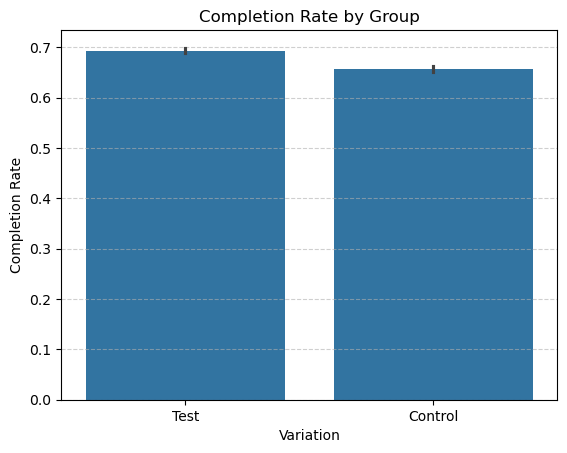

In [11]:
sns.barplot(data=df, x='Variation', y='completed', estimator=np.mean, ci=95)
plt.title('Completion Rate by Group')
plt.ylabel('Completion Rate')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


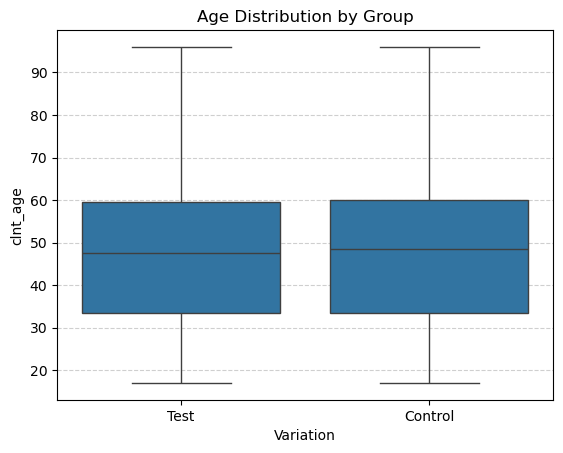

In [12]:
sns.boxplot(data=df, x='Variation', y='clnt_age')
plt.title('Age Distribution by Group')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [13]:
completion_counts = df.groupby('Variation')['completed'].value_counts().unstack().fillna(0)
print(completion_counts)

success = np.array([completion_counts.loc['Test', 1], completion_counts.loc['Control', 1]])
nobs = np.array([completion_counts.loc['Test'].sum(), completion_counts.loc['Control'].sum()])

stat, pval = proportions_ztest(success, nobs)
print(f"Z-statistic: {stat:.4f}, p-value: {pval:.4f}")
if pval < 0.05:
    print("Reject H0: Significant difference in completion rate between groups.")
else:
    print("Fail to reject H0: No significant difference.")


completed     0      1
Variation             
Control    8098  15434
Test       8281  18687
Z-statistic: 8.8745, p-value: 0.0000
Reject H0: Significant difference in completion rate between groups.


In [14]:
test_rate = success[0] / nobs[0]
control_rate = success[1] / nobs[1]
diff = test_rate - control_rate

print(f"Test Rate: {test_rate:.4f}, Control Rate: {control_rate:.4f}, Difference: {diff:.4f}")

# Test if improvement is greater than 5%
threshold = 0.05
stat, pval = proportions_ztest(success, nobs, alternative='larger')

if diff >= threshold and pval < 0.05:
    print("Reject H0: The increase is significant and exceeds the 5% threshold.")
else:
    print("Fail to reject H0: Increase does not justify cost.")


Test Rate: 0.6929, Control Rate: 0.6559, Difference: 0.0371
Fail to reject H0: Increase does not justify cost.


In [15]:
control_age = df[df['Variation'] == 'Control']['clnt_age'].dropna()
test_age = df[df['Variation'] == 'Test']['clnt_age'].dropna()

tstat, pval = stats.ttest_ind(control_age, test_age, equal_var=False)
print(f"T-statistic: {tstat:.4f}, p-value: {pval:.4f}")
if pval < 0.05:
    print("Reject H0: Average age differs between groups.")
else:
    print("Fail to reject H0: No significant difference in age.")


T-statistic: 2.4161, p-value: 0.0157
Reject H0: Average age differs between groups.


In [16]:
# Filter out unknown genders
df_gender = df[df['gendr'].isin(['M', 'F'])].copy()

# Group by gender
gender_completion = df_gender.groupby('gendr')['completed'].value_counts().unstack().fillna(0)
print(gender_completion)

# Z-test setup: Male vs Female
success = np.array([gender_completion.loc['M', 1], gender_completion.loc['F', 1]])
nobs = np.array([gender_completion.loc['M'].sum(), gender_completion.loc['F'].sum()])

stat, pval = proportions_ztest(success, nobs)
print(f"Z-statistic: {stat:.4f}, p-value: {pval:.4f}")

if pval < 0.05:
    print("Reject H0: Significant difference in completion rates between genders.")
else:
    print("Fail to reject H0: No significant gender-based difference in completion.")

completed     0      1
gendr                 
F          7870  14876
M          7422  16302
Z-statistic: 7.6019, p-value: 0.0000
Reject H0: Significant difference in completion rates between genders.


In [17]:
# Function to run and print results of gender z-test within each group
def gender_ztest_within_group(group_name):
    subset = df[(df['Variation'] == group_name) & (df['gendr'].isin(['M', 'F']))]
    completion = subset.groupby('gendr')['completed'].value_counts().unstack().fillna(0)

    success = np.array([completion.loc['M', 1], completion.loc['F', 1]])
    nobs = np.array([completion.loc['M'].sum(), completion.loc['F'].sum()])

    stat, pval = proportions_ztest(success, nobs)
    print(f"--- {group_name} Group ---")
    print(f"Z-statistic: {stat:.4f}, p-value: {pval:.4f}")
    if pval < 0.05:
        print("Reject H0: Significant gender difference in completion rate.")
    else:
        print("Fail to reject H0: No significant gender difference.")
    print()

# Run tests for each group
gender_ztest_within_group('Control')
gender_ztest_within_group('Test')


--- Control Group ---
Z-statistic: 4.0341, p-value: 0.0001
Reject H0: Significant gender difference in completion rate.

--- Test Group ---
Z-statistic: 5.5573, p-value: 0.0000
Reject H0: Significant gender difference in completion rate.



In [18]:
df_gender = df[df['gendr'].isin(['M', 'F'])]
contingency = pd.crosstab(df_gender['gendr'], df_gender['completed'])
print("Contingency Table:\n", contingency)
chi2, pval, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {pval:.4f}")
if pval < 0.05:
    print("Reject H0: There is a significant relationship between gender and completion.")
else:
    print("Fail to reject H0: No significant relationship between gender and completion.")

Contingency Table:
 completed     0      1
gendr                 
F          7870  14876
M          7422  16302
Chi-Square Statistic: 57.6390
Degrees of Freedom: 1
P-value: 0.0000
Reject H0: There is a significant relationship between gender and completion.


In [19]:
def chi_square_gender_within(group_name):
    subset = df[(df['Variation'] == group_name) & (df['gendr'].isin(['M', 'F']))]
    contingency = pd.crosstab(subset['gendr'], subset['completed'])
    print(f"--- {group_name} Group ---")
    print("Contingency Table:\n", contingency)
    chi2, pval, dof, expected = chi2_contingency(contingency)
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {pval:.4f}")
    if pval < 0.05:
        print("Reject H0: Significant relationship between gender and completion in this group.")
    else:
        print("Fail to reject H0: No significant gender relationship in this group.")
    print()

chi_square_gender_within('Control')
chi_square_gender_within('Test')

--- Control Group ---
Contingency Table:
 completed     0     1
gendr                
F          2763  4780
M          2673  5297
Chi-Square Statistic: 16.1382
P-value: 0.0001
Reject H0: Significant relationship between gender and completion in this group.

--- Test Group ---
Contingency Table:
 completed     0     1
gendr                
F          2888  5828
M          2627  6350
Chi-Square Statistic: 30.7035
P-value: 0.0000
Reject H0: Significant relationship between gender and completion in this group.



/var/folders/v_/rkcyqdxx47vbjgvjddywrbrh0000gn/T/ipykernel_17963/4078790309.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df[df['gendr'].isin(['M', 'F'])], x='gendr', y='completed', hue='Variation', estimator=np.mean, ci=95)


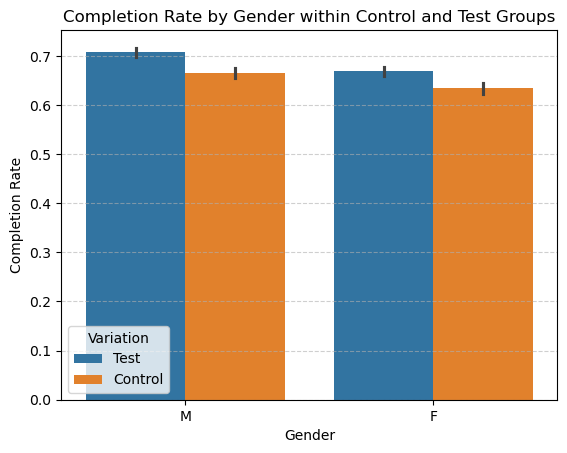

In [20]:
sns.barplot(data=df[df['gendr'].isin(['M', 'F'])], x='gendr', y='completed', hue='Variation', estimator=np.mean, ci=95)
plt.title('Completion Rate by Gender within Control and Test Groups')
plt.ylabel('Completion Rate')
plt.xlabel('Gender')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()